# STEPS:

    1. Import Libraries
    2. Take the corpus in account from where vocabulary will be created
    3. Tokenize the word of the corpus
        * Cleaning the token. (Removing any excess element from the word)
        * 

    4. Create vocabulary from the tokenize words (take account of the indices of the word)
    5. Create Embedding Layers from the vocab
    6. 

## Import required Libraries

In [113]:
import time
import re
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


import warnings
def warn(*args,**kwargs):
    pass
warnings.warn  = warn

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tinonturjamajumder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tinonturjamajumder/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Device agnostic code
device = torch.device("cpu")
device

device(type='cpu')

## Data Corpus

In [3]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Helper function

In [4]:
def preprocess_string(s):

    # remove anything but digit from string (digits,whitespaces and signs)
    s = re.sub(r"[^\w\s]",'',s)

    # remove one or more than whitespaces
    s = re.sub(r"\s+",'',s)

    # remove digits from the token
    s = re.sub(r"\d", '', s)

    return s

In [5]:
text = 'M@n06 T0r!'
processed_text = preprocess_string(text)
processed_text

'MnTr'

## Token Formation

In [6]:
def clear_token(text,tokenizer):

    token = tokenizer(text)

    tokens = [preprocess_string(w).lower() for w in token if len(w) !=0 and w not in string.punctuation]

    return tokens

In [7]:
# tokenizer instantiate
tokenizer = get_tokenizer('basic_english')

tokens = clear_token(song,tokenizer)
tokens[:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

## Vocabulary Formation

In [8]:
vocab = build_vocab_from_iterator(map(tokenizer,song.split()),specials = ["<unk>"])
vocab.set_default_index(vocab["<unk>"])                           

In [9]:
vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [10]:
index_to_token = vocab.get_itos()

## Embedding Layers

In [11]:
def genembedding(vocab,embedding_dim):


    vocab_size = len(vocab)
    embeddings = nn.Embedding(vocab_size,embedding_dim)

    return embeddings    

In [12]:
embedding = genembedding(vocab,20)
embedding

Embedding(79, 20)

In [13]:
embedding(torch.tensor(78))

tensor([-0.7748, -0.0420, -0.0022, -0.8463,  1.2822, -0.6197, -0.8038, -0.8031,
         1.1162, -0.4979,  1.0162,  0.1140, -0.5170, -0.3771,  0.9366,  0.2942,
         0.1335, -1.0048, -0.7890,  0.4615], grad_fn=<EmbeddingBackward0>)

## Generating Context-Target pairs (n-grams)

Context embedding values should be feed to the model and target word should be predicted by the model

In [14]:
def genngrams(tokens,context_size):

    context, target = [],[]
    ngrams =[
        (
            [tokens[i-j-1] for j in range(context_size)],
            tokens[i]
        )
        for i in range(context_size,len(tokens))  
    ]
        
                      
    return ngrams

In [15]:
CONTEXT_SIZE = 2

bigram_idx = genngrams(tokens,context_size = CONTEXT_SIZE)

In [16]:
bigram_idx[:10]

[(['are', 'we'], 'no'),
 (['no', 'are'], 'strangers'),
 (['strangers', 'no'], 'to'),
 (['to', 'strangers'], 'love'),
 (['love', 'to'], 'you'),
 (['you', 'love'], 'know'),
 (['know', 'you'], 'the'),
 (['the', 'know'], 'rules'),
 (['rules', 'the'], 'and'),
 (['and', 'rules'], 'so')]

## Creating Embedding (first layer) of the model

In [17]:
context,target = bigram_idx[0]

# turn the context and target into indices
print(context,target)
print(f"Context indices: {vocab(context)} Target indices: {vocab([target])}")

['are', 'we'] no
Context indices: [58, 21] Target indices: [70]


In [18]:
# Create embeddings
embedding(torch.tensor(58))

tensor([ 1.6258, -0.1898, -0.1148,  0.7887, -0.1309, -0.8208, -0.8326,  0.4208,
         0.8360,  0.0723, -1.0057,  0.0691,  0.4685,  0.6351,  0.5072,  0.1315,
         1.8798,  0.8992, -0.9187,  0.2206], grad_fn=<EmbeddingBackward0>)

In [19]:
context_vocab = vocab(context)

In [20]:
context_embedding = embedding(torch.tensor(vocab(context)))
context_embedding

tensor([[ 1.6258, -0.1898, -0.1148,  0.7887, -0.1309, -0.8208, -0.8326,  0.4208,
          0.8360,  0.0723, -1.0057,  0.0691,  0.4685,  0.6351,  0.5072,  0.1315,
          1.8798,  0.8992, -0.9187,  0.2206],
        [-0.2098,  1.1176, -1.9505,  1.0751, -0.7525,  0.6912,  0.8734, -0.3961,
          1.0350, -0.2557,  2.1782,  0.5553, -0.8472, -2.0583,  1.0261,  0.4524,
          0.1340,  0.2791, -1.2697, -0.3752]], grad_fn=<EmbeddingBackward0>)

In [21]:
context_embedding.shape

torch.Size([2, 20])

Have to concat all the tensors and create a 1 dimentional array

In [22]:
context_embedding_reshape = context_embedding.reshape(1,-1)
context_embedding_reshape.shape

torch.Size([1, 40])

## Creating Linear Layer (2nd Layer) of the model

In [23]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 20
layer2 = nn.Linear(CONTEXT_SIZE*EMBEDDING_DIM,128)

In [24]:
out = layer2(context_embedding_reshape)
out,out.shape

(tensor([[-0.6672, -1.3458,  0.1539,  1.0550,  0.1222, -0.2387, -0.5611, -0.8076,
           0.3819,  0.6714,  0.1826, -0.7333, -0.2884, -0.4137, -0.1026, -0.6231,
           0.6232, -0.3370,  0.2047, -0.7717,  0.3452, -0.0587,  0.4488,  0.3695,
          -0.5927,  0.8237, -0.8581,  0.0213,  0.6405,  0.0624, -0.5209, -0.6249,
           0.7516, -0.1868, -0.2064, -0.5800, -0.7828,  0.0937, -0.9263, -0.1683,
          -0.3000, -0.8225, -0.5184, -0.7200, -0.0355,  0.0107, -0.1706, -0.3260,
          -0.5931, -0.4128,  0.3822, -0.4904, -0.2101, -0.1564, -0.4619,  1.0603,
          -0.0417,  0.2601, -0.0317, -0.3753,  0.3825, -0.1631, -0.1595,  0.9858,
           0.3181, -0.2858, -0.2320,  0.3318,  0.3250,  0.2768,  0.0268,  0.7941,
          -0.6007,  0.1744,  0.7465, -0.9729, -0.2928,  0.1104,  0.3998, -0.5695,
          -0.4508, -0.6137, -0.0371, -0.9993, -0.0298,  0.6161,  0.2745,  0.3760,
          -0.1906,  1.1099, -0.1755, -0.1167,  0.0924, -0.3316, -0.5019, -0.0659,
           0.674

# Create Collate Function

In [77]:

CONTEXT_SIZE = 3
def collate_fn(batch):
    """
    according to the context size, we have to pass the tokens/indices to the model
    Extracts individual tokens from batch
    Parameters:
        Full token batch: so token should be turned into indices
        
    Returns:
        Tuple: Context Tensor, Target Tensor
    """
    batch_size = len(batch)
    context, target = [],[]

    for i in range(CONTEXT_SIZE, batch_size):
        target.append(vocab([batch[i]]))

        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))

    return torch.tensor(context).to(device),torch.tensor(target).to(device)
    

#### Maintain uniform length

In [78]:
BATCH_SIZE = 10
Padding = BATCH_SIZE -(len(tokens)%BATCH_SIZE)
token_pads = tokens + tokens[0:Padding]

In [79]:
len(token_pads)

350

## DataLoader Creation

In [80]:

dataloader = DataLoader(dataset = token_pads,
                       batch_size=BATCH_SIZE,
                       shuffle = False,
                       collate_fn=collate_fn)

In [81]:
first_batch = next(iter(dataloader))

In [82]:
first_batch

(tensor([[70, 58, 21],
         [74, 70, 58],
         [25, 74, 70],
         [69, 25, 74],
         [ 2, 69, 25],
         [20,  2, 69],
         [31, 20,  2]]),
 tensor([[74],
         [25],
         [69],
         [ 2],
         [20],
         [31],
         [72]]))

## Creating Multi-Class Classification Model

In [83]:
class TextMultiClassClassification(nn.Module):

    def __init__(self,vocab_size,embedding_dim,context_size):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim 
        self.context_size = context_size

        # Embedding Layer: maps vocab size into embedding values (converts words into dense vector representation)
        self.embedding_layer = nn.Embedding(vocab_size,embedding_dim)

        # Layer 1: linear layer which takes embedding layer as input.
        self.layer_1 = nn.Linear(context_size*embedding_dim,128)

        # Layer 2: takes first linear layer as input and predicts the next word
        self.layer_2 = nn.Linear(128,vocab_size)



    def forward(self,inputs):
        embedded_out = self.embedding_layer(inputs) # shpae --> (batch_size,context_size,embedding_dim)

        # reshape the output
        embedded_out_reshaped = embedded_out.reshape(-1,self.context_size*self.embedding_dim) # Shape --> (batch_size,context_size * embedding_dim)

        # Pass through the linear layer
        out = F.relu(self.layer_1(embedded_out_reshaped)) # shape --> (batch_size,128)

        # Pass through the final linear layer
        out = self.layer_2(out) # shape--> (128,len(vocab))

        return out

        

In [84]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 20
CONTEXT_SIZE = 3
model_0 = TextMultiClassClassification(vocab_size = VOCAB_SIZE,
                                      embedding_dim = EMBEDDING_DIM,
                                      context_size = CONTEXT_SIZE)

In [85]:
context,target = next(iter(dataloader))

In [86]:
output = model_0(context)
output.shape

torch.Size([7, 79])

In [87]:
pred_label = torch.argmax(output,dim =1)
pred_label,target.squeeze()

(tensor([44, 67, 75, 75, 18, 78, 67]), tensor([74, 25, 69,  2, 20, 31, 72]))

In [88]:
pred_words = [index_to_token[w.item()] for w in pred_label]
actual_words = [index_to_token[w.item()] for w in target]
pred_words,actual_words

(['just', 'guy', 'thinking', 'thinking', 'run', 'wouldnt', 'guy'],
 ['strangers', 'to', 'love', 'you', 'know', 'the', 'rules'])

## Writing a Song

In [89]:
def write_song(model,initial_context,number_of_words =100):
    """
    Generates text using a trained n-gram language model.

    Give an initial text ('my_song'), the function generates additional words by predicting the next word immediately based on the trained model.


    Parameters:
    model(nn.Module): The trained n-gram language model
    my_song(str): The initial seed text to start generating text
    number_of_words(int): The number of words generate

    Returns:
    str: The generated song lyrics as a string
    """


    # get the mapping from index to word for decoding predictions
    index_to_token = vocab.get_itos()

    # Loop to generate the desired number of words
    for i in range(number_of_words):

        with torch.inference_mode():

            # Prepare the context by extracting the last context_size words from tokens
            context = torch.tensor(
                vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])
            ).to(device)

            # Predict the next word by selecting the word with the highest probability
            word_idx = torch.argmax(model(context),dim = 1).to(device)

            # Append the predicted word to the generated text
            initial_context += " "+index_to_token[word_idx.detach().item()]

    return initial_context


        

In [90]:
generative_song = write_song(model_0,"my song")
generative_song

'my song of guy youre just guy thinking thinking run wouldnt guy aching guy run play were both thinking wouldnt and wouldnt thinking wanna play and guy what thinking thinking both and thinking play give any blind and and dont thinking dont understand on thinking wouldnt me me and if wouldnt play wouldnt guy me wouldnt gonna me thinking and wouldnt me wouldnt me understand on do wouldnt and me me shy make play let guy thinking of guy so youre we and and thinking so give thinking wouldnt were blind what and thinking and wouldnt me play youre play thinking play'

In [91]:
def randompickline(song):
    """Selects a random line from the given song text
    This function splits the song into separate lines and randomly picks one of them"""

    # Split the song into individual lines
    lines = song.split("\n")

    # Randomly select a line and remove leading/trailing whitespace
    selected_line = random.choice(lines).strip()

    return selected_line
    

In [92]:
# Randomly select a line
selected_line = randompickline(song)

# generate a new song starting with the selected line
generated_song = write_song(model_0,selected_line)

print(generated_song)

Never gonna run around and desert you of guy youre just guy thinking thinking run wouldnt guy aching guy run play were both thinking wouldnt and wouldnt thinking wanna play and guy what thinking thinking both and thinking play give any blind and and dont thinking dont understand on thinking wouldnt me me and if wouldnt play wouldnt guy me wouldnt gonna me thinking and wouldnt me wouldnt me understand on do wouldnt and me me shy make play let guy thinking of guy so youre we and and thinking so give thinking wouldnt were blind what and thinking and wouldnt me play youre play thinking play


## Training

In [93]:
from tqdm.auto import tqdm

In [94]:
def train(dataloader, model,song,loss_fn,optimizer,number_of_epochs =100,show = 10):

    MY_LOSS = []

    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0
        my_song = ""

        for context,target in dataloader:
            model.zero_grad()
            predicted = model(context)
            loss = loss_fn(predicted,target.reshape(-1))
            total_loss +=loss.item()

            loss.backward()
            optimizer.step()


        # Display progress and generate song at specified intervals
        if epoch % show ==0:
            selected_line = randompickline(song)
            my_song +=write_song(model,selected_line)

            print("Generated Song:\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))

    return MY_LOSS
            
    

In [95]:
my_loss_list = []

In [104]:
# define the context size of for the n-gram model
CONTEXT_SIZE = 2

model_2 = TextMultiClassClassification(VOCAB_SIZE,EMBEDDING_DIM,CONTEXT_SIZE)

# define the optimizer and loss function for training model
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Set up lr scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 1.0,gamma = 0.1)

In [105]:
my_loss = train(dataloader,model_2,song,loss_fn,optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

Generated Song:

Never gonna say goodbye you never you guy desert game you gonna desert each guy never you goodbye on tell desert goodbye guy play desert never gonna to were get wanna were get were youre get were wanna you tell never desert on get gonna to guy wanna never guy how you wanna you were to gonna wanna you were never guy guy were wanna you gonna to guy wanna you never gonna wanna never never so tell you you to play guy get how other tell never desert each desert you guy each desert gonna you never never get desert desert me each
Generated Song:

Inside we both know whats been going on you never you gonna never gonna you gonna never never gonna never you gonna never never never you you never you gonna gonna never never gonna never gonna gonna gonna never gonna gonna gonna you never never you gonna you gonna never gonna tell you gonna never gonna tell you gonna never gonna tell you and never you never gonna tell you gonna never gonna tell you never gonna tell you you and you y

## SAVE THE MODEL

In [107]:
save_path = '2gram.pth'
torch.save(model_2.state_dict(),save_path)

In [108]:
my_loss_list.append(my_loss)

In [110]:
CONTEXT_SIZE = 4
model_4 = TextMultiClassClassification(len(vocab),
                                      EMBEDDING_DIM,
                                      CONTEXT_SIZE)

optimizer = torch.optim.SGD(model_4.parameters(),
                           lr = 0.01)

loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma = 0.1)
my_loss = train(dataloader,model_4,song,loss_fn,optimizer)

save_path = '4gram.pth'
torch.save(model_4.state_dict(),save_path)

my_loss_list.append(my_loss)


  0%|          | 0/100 [00:00<?, ?it/s]

Generated Song:

Never gonna say goodbye make were never never gonna thinking you never gonna never you were around never never get you thinking known give <unk> it thinking gonna guy you guy make wanna get were around so thinking around feeling how gotta feeling you never gonna gonna too it the gonna gonna too you known gonna never were commitments never see were never gonna never you never gonna gonna never you never gonna you you make around im known make around never you wanna wanna a were thinking commitments <unk> were around get get so around weve whats gonna you never see were were
Generated Song:

Never gonna give you up never never gonna you you never you never never gonna you never you never gonna you you and you never tell make you gonna make you make never never never never make you you never gonna feeling gotta make you never gonna gonna let you up never gonna let you never never gonna let you and never you never gonna make you never never gonna say you never gonna tell a

In [111]:
CONTEXT_SIZE = 8
model_8 = TextMultiClassClassification(len(vocab),
                                      EMBEDDING_DIM,
                                      CONTEXT_SIZE)

optimizer = torch.optim.SGD(model_8.parameters(),
                           lr = 0.01)

loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma = 0.1)
my_loss = train(dataloader,model_8,song,loss_fn,optimizer)

save_path = '8gram.pth'
torch.save(model_8.state_dict(),save_path)

my_loss_list.append(my_loss)


  0%|          | 0/100 [00:00<?, ?it/s]

Generated Song:

Never gonna run around and desert you i you make you tell weve you full i and shy see known never <unk> and say you weve aching this commitments full each say you make known for i rules never you you you down make never make you you other make other you you you so commitments you you make you you you you this commitments never gonna shy you you each gonna you you you gonna known you you make you you i you make full you you hearts both hearts other you say make you shy other shy you make never you aching you you you
Generated Song:

Never gonna give you up never gonna make you you love you never the rules gonna tell you you it make you you never thinking never you never never make you gonna you guy i you make you you never you make never make you you never gonna make you down gonna gonna let you down never tell run around and never tell never gonna make you down never gonna say you you gonna tell a lie never hurt you never you make you for so never make you you you you 

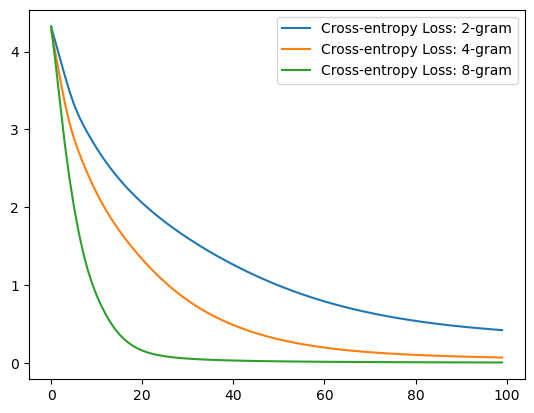

In [114]:
for (my_loss,model_name) in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label =f"Cross-entropy Loss: {model_name}")
    plt.legend()

## Perplexity

Perplexity is a measurement used to evaluate the effectiveness of language models or probability models. It provides an indication of how well a model predicts a sample of data or the likelihood of an unseen event. Perplexity is commonly used in natural language processing tasks, such as `machine translation`, `speech recognition`, and `language generation`.

Perplexity is derived from the concept of cross-entropy loss, which measures the dissimilarity between predicted probabilities and actual probabilities. 

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$
The cross-entropy loss is calculated by taking the negative sum of the products of the true labels $y_i$ and the logarithm of the predicted probabilities $p_i$ over $N$ classes.

Taking the exponential of the mean cross-entropy loss gives us the perplexity value.

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$


A *`lower perplexity`* value indicates that the model is more `confident` and `accurate` in predicting the data. Conversely, a `higher perplexity` suggests that the model is less certain and less accurate in its predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence. A lower perplexity means that the model is more certain about the next word, while a higher perplexity means that there are more possible choices.


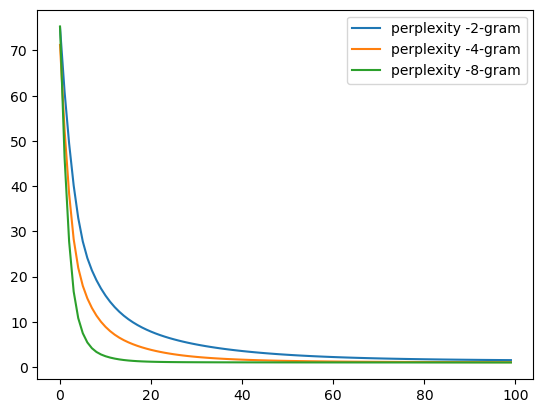

In [115]:
for (my_loss,model_name) in zip(my_loss_list,["2-gram","4-gram","8-gram"]):

    # calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label = f"perplexity -{model_name}")
    plt.legend()
